# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='./data')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

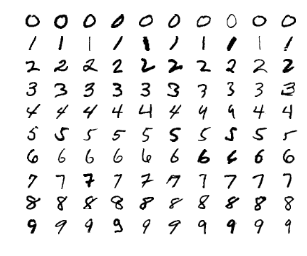

In [3]:
def P1(num_examples=10):

### STUDENT START ###
    
    ''' Only work with more than 1 example '''
    if num_examples < 1: raise Exception('Need at least 1 example')
        
    ''' Setup multi plot '''
    plt.rc('image',cmap='gist_yarg')
    fig, axes = plt.subplots(10,num_examples)
    fig.set_figheight(10/2.5)
    fig.set_figwidth(num_examples/2)
    
    ''' Loop through and plot examples '''
    for i in range(10):
        labelnums = [ m for m,y in enumerate(mini_train_labels) if y==i ]
        for x in range(num_examples):
            trainnum = labelnums[x]
            if num_examples != 1:
                axes[i,x].imshow(mini_train_data[trainnum].reshape((28,28)))
                axes[i,x].axis('off')
            else:
                axes[i].imshow(mini_train_data[trainnum].reshape((28,28)))
                axes[i].axis('off')

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [9]:
def P2(k_values):

### STUDENT START ###

    ''' Build multiple knn models for each 
        k value passed as a parameter
    '''
    ks = [ KNeighborsClassifier(n_neighbors = k) for k in k_values ]
    accuracies = []
    
    ''' Loop through knn models, fit data & make preditions
        Print classification report when k is equal to 1
    '''
    for i,k in enumerate(k_values):
        ks[i].fit(mini_train_data, mini_train_labels)
        predictions = ks[i].predict(dev_data)
        # results = zip(predictions, dev_labels)
        # accuracy = round(sum(map(lambda x: x[0]==x[1], results))*1.0 / len(results),2)
        accuracy = round(np.mean(predictions == dev_labels),2)
        accuracies.append((k,accuracy))
        if k==1: 
            print classification_report(predictions, dev_labels)
    
    ''' Return a list of tuples with k and accuracy '''
    return accuracies

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

             precision    recall  f1-score   support

        0.0       0.98      0.91      0.94       107
        1.0       1.00      0.89      0.94       118
        2.0       0.79      0.99      0.88        82
        3.0       0.87      0.77      0.82        97
        4.0       0.82      0.89      0.85        96
        5.0       0.84      0.93      0.88        82
        6.0       0.96      0.94      0.95       100
        7.0       0.92      0.89      0.90       117
        8.0       0.88      0.94      0.91        89
        9.0       0.82      0.78      0.80       112

avg / total       0.89      0.89      0.89      1000



[(1, 0.89), (3, 0.88), (5, 0.87), (7, 0.86), (9, 0.86)]

ANSWER: 

Accuracies:
k=1: 89%
k=3: 88%
k=5: 87%
k=7: 86%
k=9: 86%

The most difficult digit to predict is digit '9', based on the f1-score, which is a weighted harmonic mean of the precision and recall metrics. The digit '9' has the lowest precision score - which is tp / (tp + fp), or intuitively the ability of the classifier not to label as positive a sample that is negative - and it has second lowest recall - which is tp / (tp + fn), or intuitively the ability of the classifier to find all the positive samples. (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [11]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    
    ''' Create a knn model for each train size '''
    ks = [ KNeighborsClassifier(n_neighbors = 1) for k in train_sizes ]
    times = []
    
    ''' Loop through knn models, fit data & measure accuracy of prediction '''
    for i,k in enumerate(train_sizes):
        ks[i].fit(train_data[:k], train_labels[:k])
        start = time.time()
        predictions = ks[i].predict(dev_data)
        end = time.time()
        times.append((k,round(end-start,4)))
        # results = zip(predictions, dev_labels)
        # accuracy = round(sum(map(lambda x: x[0]==x[1], results))*1.0 / len(results),3)
        accuracy = round(np.mean(predictions == dev_labels),3)
        accuracies.append((k,accuracy))
    
    ''' Crete a list of output strings to print '''
    accuracy_strs = ['For size {0}, accuracy was {1}%'.format(k,a*100) for k,a in accuracies ]
    time_strs = ['& time for prediction was {1} seconds'.format(k, t) for k,t in times]
    all_strs = zip(accuracy_strs,time_strs)
    all_strs = map(lambda x: ' '.join(x), all_strs)
    
    print '\n'.join(all_strs)

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For size 100, accuracy was 72.0% & time for prediction was 0.1093 seconds
For size 200, accuracy was 78.6% & time for prediction was 0.2144 seconds
For size 400, accuracy was 84.1% & time for prediction was 0.4293 seconds
For size 800, accuracy was 88.4% & time for prediction was 0.9995 seconds
For size 1600, accuracy was 90.2% & time for prediction was 1.9564 seconds
For size 3200, accuracy was 92.6% & time for prediction was 3.7461 seconds
For size 6400, accuracy was 93.7% & time for prediction was 7.7071 seconds
For size 12800, accuracy was 95.9% & time for prediction was 14.8629 seconds
For size 25000, accuracy was 97.0% & time for prediction was 29.594 seconds


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [18]:
def P4():

### STUDENT START ###
    from math import log, exp
    
    ''' Load accuracy results from problem #3 '''
    accuracies = [(100, 0.72),
                 (200, 0.786),
                 (400, 0.841),
                 (800, 0.884),
                 (1600, 0.902),
                 (3200, 0.926),
                 (6400, 0.937),
                 (12800, 0.959),
                 (25000, 0.97)]
    
    ''' Create vector tuples for size and accuracy '''
    size, accuracy = zip(*accuracies)
    
    ''' Turn each value into a 1x1 matrix '''
    vectorize = lambda x: [x]
    size = map(vectorize, size)
    accuracy_rate = map(vectorize, accuracy)
    
    ''' Do a log transformation for each accuracy value '''
    accuracy_log = map(lambda x: [log(1-x)], accuracy)
    
    ''' Create a linear regression model for both 
        normal accuracy value and log-transformed value
    '''
    lm = LinearRegression()
    lm_log = LinearRegression()
    lm.fit(size, accuracy_rate)
    lm_log.fit(size, accuracy_log)
    
    ''' Generate predictions for both models and print results '''
    print str(round(lm.predict(60000)[0][0],3)*100)+'%'
    print str(round(1-exp(lm_log.predict(60000)[0][0]),3)*100)+'%'

### STUDENT END ###

P4()

124.3%
99.8%


ANSWER:

The prediction from a linear regression model is 124%, which is nonsensical since it is above 100%. 
A transformation can be made by taking the log of 1 minus accuracy, and then take the exponent of the predicted value and subtract from 1. The result will never be above 100% in this case. An example of this transformation is shown above.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

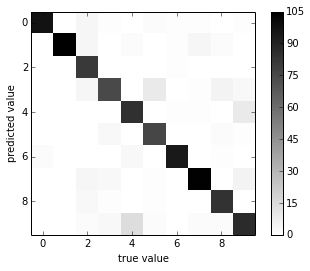

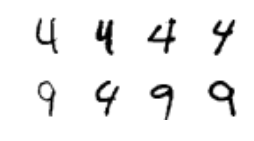

In [13]:
def P5():

### STUDENT START ###
    def plot_confusion_matrix(y_pred, y):
        ''' Plot confusion matrix. Code taken from:
            http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/18_IntermediateSklearn
        '''
        plt.imshow(confusion_matrix(y, y_pred),
               cmap=plt.cm.binary, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('true value')
        plt.ylabel('predicted value')
    
    ''' Generate knn model, fit data and generate confusion matrix '''
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(mini_train_data, mini_train_labels)
    predictions = knn.predict(dev_data)
    plot_confusion_matrix(dev_labels, predictions)
    
    ''' Find some example observations where model was incorrect '''
    results = zip(dev_labels,predictions)
    incorrect_4s = [ i for i,r in enumerate(results) if r[0]==4 and r[1]==9]
    incorrect_9s = [ i for i,r in enumerate(results) if r[0]==9 and r[1]==4]
    
    ''' Show example mistakes '''
    fig, axes = plt.subplots(2,4)
    fig.set_figheight(2)
    fig.set_figwidth(4)
    for i in range(4):
        axes[0,i].imshow(dev_data[incorrect_4s[i]].reshape((28,28)))
        axes[0,i].axis('off')
    for i in range(4):
        axes[1,i].imshow(dev_data[incorrect_9s[i]].reshape((28,28)))
        axes[1,i].axis('off')
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Accuracy in case "preprocess the training data but not the dev data" was 88.8%
Accuracy in case "preprocess the dev data but not the training data" was 88.3%
Accuracy in case "preprocess both training and dev data" was 89.2%


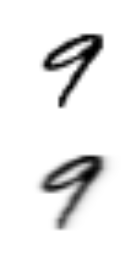

In [23]:
def P6():
    
### STUDENT START ###
    
    from math import pi, e, sqrt
    
    def gauss(xblock, sigma=1):
        ''' Return sum of gaussian-weighted values
            where origin is the middle value
        '''
        xn = np.zeros(len(xblock))
        for i in range(len(xblock)): 
            xn[i] = i-len(xblock)//2
            xn[i] = (1.0 / sqrt(2*pi*sigma**2)) * e**(-1.0*(xn[i]**2)/(2*sigma**2))
        return sum(xn*xblock)
    
    def blur(arr):
        ''' Iterate through a pixel array and return
            a new array that is blurred using 
            gaussian function 
        '''
        arrnew = arr.copy()
        for i in range(len(arrnew)):
                arrnew[i] = gauss(arrnew[i-4:i+5])
        return arrnew
    
    def show_example(training_observation):
        ''' Function to display two images
            First is unblurred
            Second with blur function
        '''
        fig, axes = plt.subplots(2,1)
        axes[0].imshow(training_observation.reshape((28,28)))
        axes[0].axis('off')
        x = blur(training_observation)
        axes[1].imshow(x.reshape((28,28)))
        axes[1].axis('off')
    
    def run_model():
        ''' Blur datasets, and run classification model
        '''
        
        ''' Blur datasets '''
        blurred_train = mini_train_data.copy()
        blurred_dev = dev_data.copy()
        for i in range(len(blurred_train)): blurred_train[i] = blur(mini_train_data[i])
        for i in range(len(blurred_dev)): blurred_dev[i] = blur(dev_data[i])
            
        ''' Display an example '''
        show_example(mini_train_data[15])

        ''' Create classifiers '''
        knn_1 = KNeighborsClassifier(n_neighbors = 1)
        knn_2 = KNeighborsClassifier(n_neighbors = 1)
        knn_3 = KNeighborsClassifier(n_neighbors = 1)

        ''' Fit classifiers'''
        knn_1.fit(blurred_train, mini_train_labels)
        knn_2.fit(mini_train_data, mini_train_labels)
        knn_3.fit(blurred_train, mini_train_labels)

        ''' Make predictions '''
        predictions_1 = knn_1.predict(dev_data)
        predictions_2 = knn_2.predict(blurred_dev)
        predictions_3 = knn_3.predict(blurred_dev)

        ''' Measure accuracies '''
        accuracy_1 = np.mean(predictions_1 == dev_labels)
        accuracy_2 = np.mean(predictions_2 == dev_labels)
        accuracy_3 = np.mean(predictions_3 == dev_labels)

        ''' Report on accuracy '''
        reportstr = 'Accuracy in case "{0}" was {1}%'
        print reportstr.format('preprocess the training data but not the dev data',round(accuracy_1,3)*100)
        print reportstr.format('preprocess the dev data but not the training data',round(accuracy_2,3)*100)
        print reportstr.format('preprocess both training and dev data',round(accuracy_3,3)*100)
    
    run_model()
    
### STUDENT END ###

P6()

ANSWER:

Accuracy in case "preprocess the training data but not the dev data" was 88.8%
Accuracy in case "preprocess the dev data but not the training data" was 88.3%
Accuracy in case "preprocess both training and dev data" was 89.2%

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

Bernoulli model report:
             precision    recall  f1-score   support

        0.0       0.98      0.91      0.94       107
        1.0       0.93      0.82      0.87       119
        2.0       0.79      0.85      0.82        95
        3.0       0.74      0.62      0.67       104
        4.0       0.79      0.90      0.84        91
        5.0       0.62      0.85      0.71        66
        6.0       0.87      0.89      0.88        95
        7.0       0.80      0.92      0.85        98
        8.0       0.80      0.75      0.77       103
        9.0       0.82      0.71      0.76       122

avg / total       0.82      0.82      0.82      1000
Multinomial model report:
             precision    recall  f1-score   support

        0.0       0.97      0.90      0.93       107
        1.0       0.92      0.87      0.90       111
        2.0       0.81      0.84      0.83        99
        3.0       0.74      0.65      0.69        99
        4.0       0.69      0.92      0.79    

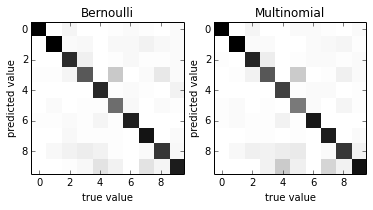

In [24]:
def P7():

### STUDENT START ###

    ''' Fit a bernoulli naive bayes model '''
    nbb = BernoulliNB(binarize=0.5)
    nbb.fit(mini_train_data, mini_train_labels)
    nbb_predictions = nbb.predict(dev_data)
    
    def multi_apply(arr):
        ''' Take an array of pictures with pixel values
            mapped to 0, 1, or 2 representing white, 
            grey, or black.
        '''
        newarr = arr.copy()
        
        def check_val(x):
            ''' code values as 0 1 or 2 '''
            if x<0.34: return 0 
            elif x<=0.66: return 1
            else: return 2
        
        for i in range(arr.shape[0]):
            newarr[i] = [ check_val(z) for z in arr[i] ]
        
        return newarr
    
    ''' Create a multinomial model with coded values 0 1 and 2 '''
    multi_train_data, multi_dev_data = np.zeros(mini_train_data.shape[0]), np.zeros(dev_data.shape[0])
    multi_train_data, multi_dev_data = multi_apply(mini_train_data), multi_apply(dev_data)
    nbm = MultinomialNB()
    nbm.fit(multi_train_data, mini_train_labels)
    nbm_predictions = nbm.predict(multi_dev_data)
    
    ''' Plot confusion matrix '''
    fig, axes = plt.subplots(1,2)
        
    def plot_confusion_matrix(y_pred, y, i, title):
        ''' http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/18_IntermediateSklearn
        '''
        axes[i].imshow(confusion_matrix(y, y_pred),
               cmap=plt.cm.binary, interpolation='nearest')
        axes[i].set_title(title)
        axes[i].set_xlabel('true value')
        axes[i].set_ylabel('predicted value')
    
    plot_confusion_matrix(dev_labels, nbb_predictions, 0, 'Bernoulli')
    plot_confusion_matrix(dev_labels, nbm_predictions, 1, 'Multinomial')
    
    print 'Bernoulli model report:\n', \
        classification_report(nbb_predictions,dev_labels), \
        'Multinomial model report:\n', \
        classification_report(nbm_predictions,dev_labels)
    
### STUDENT END ###

P7()

ANSWER:

The multi-class version makes the overall performance of the model worse. Recall for some numbers, such as the numbers 1, 3, 4, and 7, are improved, while the majority of the numbers are better off in the binary model. For the number 4, recall is higher in the multinomial model but the precision is much lower compared to the binomial model, implying that the binomial model is better in terms of rate of relevant true predictions but worse in terms of false negatives, meaning that it is misclassifying a lot of 4s (i.e. as 9s). Most likely the binary selection improves accuracy because it makes a 4 appear much different from a 9 to the bayes model, and a similar effect is seen with other numbers - with greater differentiation between potential outcomes, the greater the accuracy of model prediction will be.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

[mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}]


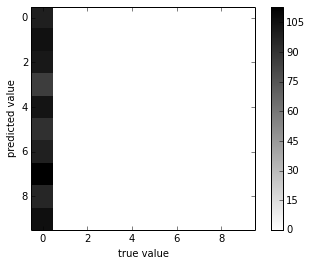

In [28]:
def P8(alphas):

### STUDENT START ###
    def plot_confusion_matrix(y_pred, y):
        ''' http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/18_IntermediateSklearn
        '''
        plt.imshow(confusion_matrix(y, y_pred),
               cmap=plt.cm.binary, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('true value')
        plt.ylabel('predicted value')
    
    ''' Create bernoulli model to run GridSearch over 
        with given alpha parameters 
    '''
    nbb = BernoulliNB(binarize=0.5)
    gbb = GridSearchCV(nbb,alphas)
    gbb.fit(mini_train_data,mini_train_labels)
    
    ''' Specifically test accuracy of bernoulli model with alpha = 0 '''
    nbb_test = BernoulliNB(alpha=0.0, binarize=0.5)
    nbb_test.fit(mini_train_data,mini_train_labels)
    predictions = nbb_test.predict(dev_data)
    plot_confusion_matrix(predictions, dev_labels)
    
    print [ x for x in gbb.grid_scores_ if x.parameters == {'alpha':0.0} ]

    return gbb
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

In [27]:
print nb.best_params_

{'alpha': 0.01}


ANSWER:
The best value for alpha is 0.01. The accuracy when alpha=0 is only 0.092. I would not expect the accuracy with no smoothing to be essentially equal to the probability of randomly guessing - it seems that without smoothing the accuracy should not be reduced so far. Since smoothing is supposed to make the model to better generalize, you would actually expect the accuracy to be higher with smoothing equal to zero (meaning that the model would be potentially overfitting the data).

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [72]:
def P9():

### STUDENT END ###
    
    ''' Create a gaussian naive bayes model 
        Fit data, make predictions and measure accuracy
    '''
    nbg = GaussianNB()
    nbg.fit(mini_train_data, mini_train_labels)
    predictions = nbg.predict(dev_data)
    print 'Base model:',np.mean(predictions==dev_labels)
    
    def binarize(a):
        ''' Binarize values in array (as 0 or 1) '''
        a_copy = np.zeros(a.shape)
        for i in range(a.shape[1]):
            a_copy[:,i] = a[:,i]>=0.8
        return a_copy
    
    ''' Test out a binarized dataset with gaussian model '''
    new_mini_data = binarize(mini_train_data)
    nbg_new = GaussianNB()
    nbg_new.fit(new_mini_data, mini_train_labels)
    new_dev_data = binarize(dev_data)
    new_predictions = nbg_new.predict(new_dev_data)
    print 'Binarized model:',np.mean(new_predictions==dev_labels)
    
    return nbg_new
    
### STUDENT END ###

gnb = P9()

Base model: 0.627
Binarized model: 0.66


ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

(10, 784)


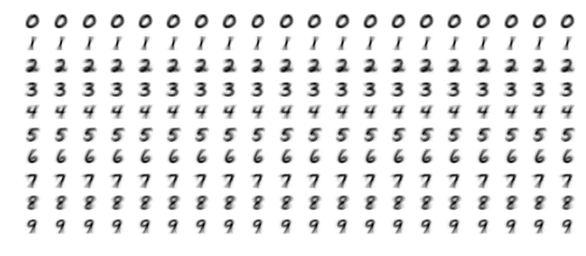

In [66]:
def P10(num_examples):

### STUDENT START ###

    ''' Create bernoulli model and fit data'''
    nbb = BernoulliNB(binarize=0.5)
    nbb.fit(mini_train_data,mini_train_labels)
    
    ''' Gather probability matrix '''
    probs = nbb.feature_log_prob_
    
    ''' Create subplot matrix to show examples '''
    plt.rc('image',cmap='gist_yarg')
    fig, axes = plt.subplots(10,num_examples)
    fig.set_figheight(10/2.5)
    fig.set_figwidth(num_examples/2)
    
    ''' Loop through and generate examples '''
    for i in range(10):
        for x in range(num_examples):
            rnds = np.random.rand(784)
            if num_examples != 1:
                axes[i,x].imshow((rnds+255*np.exp(probs[i])).reshape((28,28)))
                axes[i,x].axis('off')
            else:
                axes[i].imshow((rnds+255*np.exp(probs[i])).reshape((28,28)))
                axes[i].axis('off')

### STUDENT END ###

P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [75]:
def P11(buckets, correct, total):
    
### STUDENT START ###

    ''' Create bernoulli model with alpha and binarize set 
        and fit training data 
    '''
    nbb = BernoulliNB(alpha=0.01,binarize=0.5)
    nbb.fit(mini_train_data,mini_train_labels)
    
    ''' Find probability value for each posterior maximum 
        and make predictions from dev_data
    '''
    probs = np.max(nbb.predict_proba(dev_data),axis=1)
    predictions = nbb.predict(dev_data)
    
    ''' Use numpy digitize to bucket probabilities '''
    x = np.digitize(probs,buckets)-1
    
    ''' Measure accuracy for each bucket '''
    r = np.zeros(len(predictions))
    for i in range(len(buckets)): 
        correct[i] = np.sum(np.logical_and(predictions==dev_labels, x==(r+i)))*1.0
        total[i] = np.sum(x == i)*1.0
    return buckets, correct, total
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0.0 for i in buckets]
total = [0.0 for i in buckets]

buckets, correct, total = P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =  30    accuracy = 0.200
p(pred) <= 0.9000000000000    total =  87    accuracy = 0.460
p(pred) <= 0.9990000000000    total =  84    accuracy = 0.619
p(pred) <= 0.9999900000000    total =  58    accuracy = 0.690
p(pred) <= 0.9999999000000    total =  59    accuracy = 0.763
p(pred) <= 0.9999999990000    total =  76    accuracy = 0.868
p(pred) <= 0.9999999999900    total =  75    accuracy = 0.840
p(pred) <= 0.9999999999999    total =  33    accuracy = 0.879
p(pred) <= 1.0000000000000    total = 498    accuracy = 0.958


ANSWER:
The model appears to be poorly calibrated since values at higher thresholds have better accuracies. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

Accuracy of enclosed model: 0.952
Accuracy of categorized model: 0.915
Accuracy of primes model: 1.0
Accuracy of nf model: 0.949
Accuracy of tf model: 0.958
Accuracy of sn model: 0.941
Accuracy of it model: 0.967
             precision    recall  f1-score   support

        0.0       0.96      0.90      0.93       105
        1.0       0.94      0.97      0.96       102
        2.0       0.83      0.90      0.87        94
        3.0       0.85      0.68      0.76       107
        4.0       0.73      0.95      0.83        80
        5.0       0.71      0.88      0.79        74
        6.0       0.92      0.90      0.91       100
        7.0       0.83      0.96      0.89        98
        8.0       0.89      0.86      0.87        99
        9.0       0.93      0.70      0.80       141

avg / total       0.87      0.86      0.86      1000

Accuracy of baseline model: 0.816
Accuracy of final model: 0.861


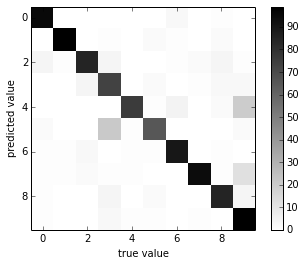

In [155]:
def P12():

### STUDENT START ###
    ''' Create copy of datasets '''
    new_dev_data = dev_data.copy()
    new_train_data = mini_train_data.copy()
    
    ''' Add summed column using numpy-foo '''
    summed_col = np.sum(new_dev_data,axis=1)[...,None]
    summed_col_train = np.sum(new_train_data,axis=1)[...,None]
    
    ''' Count number of enclosed regions '''
    def count_enclosed(n):
        if n==4 or n==6 or n==9 or n==0: return 1
        elif n==8: return 2
        else: return 0
    count_enclosed = np.vectorize(count_enclosed,otypes=[np.int8])
    enclosed_labels = count_enclosed(mini_train_labels)
    enclosed_model = KNeighborsClassifier(n_neighbors = 1)#MultinomialNB(alpha=0.01)
    enclosed_model.fit(mini_train_data, enclosed_labels)
    enclosed_pred = enclosed_model.predict(new_dev_data)
    print 'Accuracy of enclosed model:',np.mean(enclosed_pred==count_enclosed(dev_labels))
   
    ''' Categorize shapes as round (0), sharp (2), or both (1)'''
    def categorize_digit(n):
        if n==1 or n==4 or n==7: return 0
        if n==5 or n==2: return 1
        else: return 2 
    categorize_digit = np.vectorize(categorize_digit,otypes=[np.int8])
    categorized_labels = categorize_digit(mini_train_labels)
    categorized_model = KNeighborsClassifier(n_neighbors = 1)#MultinomialNB(alpha=0.01)
    categorized_model.fit(mini_train_data, categorized_labels)
    categorized_pred = categorized_model.predict(new_dev_data)
    print 'Accuracy of categorized model:',np.mean(categorized_pred==categorize_digit(dev_labels))
    
    ''' Label as prime number '''
    def primes(n):
        if n==2 or n==3 or n==5 or n==7: return 0 
        else: return 0
    primes = np.vectorize(primes,otypes=[np.int8])
    primes_labels = primes(mini_train_labels)
    primes_model = KNeighborsClassifier(n_neighbors = 1)
    primes_model.fit(mini_train_data, primes_labels)
    primes_pred = primes_model.predict(new_dev_data)
    print 'Accuracy of primes model:',np.mean(primes_pred==primes(dev_labels))
    
    ''' Try to separate 9s and 4s '''
    def nines_fours(n):
        if n==4: return 1
        elif n==9: return 2
        else: return 0 
    nines_fours = np.vectorize(nines_fours,otypes=[np.int8])
    nf_labels = nines_fours(mini_train_labels)
    nf_model = KNeighborsClassifier(n_neighbors = 1)
    nf_model.fit(mini_train_data, nf_labels)
    nf_pred = nf_model.predict(new_dev_data)
    print 'Accuracy of nf model:',np.mean(nf_pred==nines_fours(dev_labels))
    
    ''' Try to separate 3s and 5s '''
    def threes_fives(n):
        if n==3: return 1
        elif n==5: return 2
        else: return 0 
    threes_fives = np.vectorize(threes_fives,otypes=[np.int8])
    tf_labels = threes_fives(mini_train_labels)
    tf_model = KNeighborsClassifier(n_neighbors = 1)
    tf_model.fit(mini_train_data, tf_labels)
    tf_pred = tf_model.predict(new_dev_data)
    print 'Accuracy of tf model:',np.mean(tf_pred==threes_fives(dev_labels))
    
    ''' Try to separate 7s and 9s '''
    def sevens_nines(n):
        if n==7: return 1
        elif n==9: return 2
        else: return 0 
    sevens_nines = np.vectorize(sevens_nines,otypes=[np.int8])
    sn_labels = sevens_nines(mini_train_labels)
    sn_model = KNeighborsClassifier(n_neighbors = 1)
    sn_model.fit(mini_train_data, sn_labels)
    sn_pred = sn_model.predict(new_dev_data)
    print 'Accuracy of sn model:',np.mean(sn_pred==sevens_nines(dev_labels))
    
    ''' Try to pick up more threes '''
    def is_three(n):
        if n==3: return 1 
        else: return 0
    is_three = np.vectorize(is_three,otypes=[np.int8])
    it_labels = is_three(mini_train_labels)
    it_model = KNeighborsClassifier(n_neighbors = 1)
    it_model.fit(mini_train_data, it_labels)
    it_pred = it_model.predict(new_dev_data)
    print 'Accuracy of it model:',np.mean(it_pred==is_three(dev_labels))
    
    ''' Add new columns '''
    new_dev_data = np.concatenate((new_dev_data, summed_col), 1)
    new_dev_data = np.concatenate((new_dev_data, enclosed_pred[...,None]),1)
    new_dev_data = np.concatenate((new_dev_data, categorized_pred[...,None]),1)
    new_dev_data = np.concatenate((new_dev_data, primes_pred[...,None]),1)
    new_dev_data = np.concatenate((new_dev_data, nf_pred[...,None]),1)
    new_dev_data = np.concatenate((new_dev_data, tf_pred[...,None]),1)
    new_dev_data = np.concatenate((new_dev_data, sn_pred[...,None]),1)
    new_dev_data = np.concatenate((new_dev_data, it_pred[...,None]),1)
    new_train_data = np.concatenate((new_train_data, summed_col_train), 1)
    new_train_data = np.concatenate((new_train_data, enclosed_labels[...,None]),1)
    new_train_data = np.concatenate((new_train_data, categorized_labels[...,None]),1)
    new_train_data = np.concatenate((new_train_data, primes_labels[...,None]),1)
    new_train_data = np.concatenate((new_train_data, nf_labels[...,None]),1)
    new_train_data = np.concatenate((new_train_data, tf_labels[...,None]),1)
    new_train_data = np.concatenate((new_train_data, sn_labels[...,None]),1)
    new_train_data = np.concatenate((new_train_data, it_labels[...,None]),1)
    
    ''' Run model with new columns '''
    nbm = MultinomialNB(alpha=0.01)
    nbm.fit(new_train_data, mini_train_labels)
    predictions_nbm = nbm.predict(new_dev_data)
    
    ''' Run a baseline model also '''
    nbb = BernoulliNB(alpha=0.01)
    nbb.fit(mini_train_data, mini_train_labels)
    predictions_nbb = nbb.predict(dev_data)
    
    ''' Analyze performance '''
    def plot_confusion_matrix(y_pred, y):
        ''' Plot confusion matrix. Code taken from:
            http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/18_IntermediateSklearn
        '''
        plt.imshow(confusion_matrix(y, y_pred),
               cmap=plt.cm.binary, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('true value')
        plt.ylabel('predicted value')
    
    plot_confusion_matrix(predictions_nbm, dev_labels)
    print classification_report(predictions_nbm, dev_labels)
    print 'Accuracy of baseline model:',np.mean(predictions_nbb==dev_labels)
    print 'Accuracy of final model:',np.mean(predictions_nbm==dev_labels)

### STUDENT END ###

P12()